In [1]:
import time
import numpy as np
import pandas as pd
import torch
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch.nn as nn

In [2]:
file_path = "datasets/test.csv"
raw_data = pd.read_csv(file_path)

# Define bid/ask columns and feature columns
levels = 5
bid_price_cols = [f"bids[{i}].price" for i in range(levels)]
ask_price_cols = [f"asks[{i}].price" for i in range(levels)]
feature_columns = bid_price_cols + ask_price_cols

# Compute mid_price and ensure numeric types
raw_data["mid_price"] = (raw_data[bid_price_cols[0]] + raw_data[ask_price_cols[0]]) / 2
raw_data[feature_columns] = raw_data[feature_columns].astype(float)
raw_data["mark_price"] = raw_data["mark_price"].astype(float)

# --- Compute VWAP_bid, VWAP_ask, and spread for the heuristic method ---
# Note: This assumes that for each row, the bid and ask amount columns exist.
# You may need to adjust if your CSV has separate columns for amounts.
raw_data["VWAP_bid"] = sum(raw_data[f"bids[{i}].price"] * raw_data[f"bids[{i}].amount"] for i in range(levels)) / \
                        sum(raw_data[f"bids[{i}].amount"] for i in range(levels))
raw_data["VWAP_ask"] = sum(raw_data[f"asks[{i}].price"] * raw_data[f"asks[{i}].amount"] for i in range(levels)) / \
                        sum(raw_data[f"asks[{i}].amount"] for i in range(levels))
raw_data["spread"] = raw_data["VWAP_ask"] - raw_data["VWAP_bid"]

# For simulation purposes, we use the entire dataset.
eval_data_ml = raw_data.reset_index(drop=True)

# only for lr_2lebels
bid_cols_full = [f"bids[{i}].price"  for i in range(levels)] + \
                [f"bids[{i}].amount" for i in range(levels)]
ask_cols_full = [f"asks[{i}].price"  for i in range(levels)] + \
                [f"asks[{i}].amount" for i in range(levels)]
feature_cols_full = bid_cols_full + ask_cols_full

## Herustic Method

In [3]:
from Hueristic_methods.Heuristic_Method import hueristic_Method
heuristic_model = hueristic_Method(raw_data.copy(), raw_data.copy(), levels)



## ML(adaboost, linear regression and SVR)

In [4]:
adaboost_model = joblib.load("ML/adaboost_model.pkl", mmap_mode=None)
GB_model = joblib.load("ML/GB_model.pkl", mmap_mode=None)
lr_model = joblib.load("ML/lr_model.pkl", mmap_mode=None)
svr_model = joblib.load("ML/svr_model.pkl", mmap_mode=None)
lr2_model = joblib.load("ML/lr_two_label.pkl")



## LSTM and OPTM LSTM model load and definition

In [5]:
data_nn = raw_data.copy()
scaler_X = StandardScaler()
data_nn[feature_columns] = scaler_X.fit_transform(data_nn[feature_columns].astype(float))
scaler_target = StandardScaler()
data_nn["mark_price_scaled"] = scaler_target.fit_transform(data_nn[["mark_price"]])
scaler_mid = StandardScaler()
data_nn["mid_price_scaled"] = scaler_mid.fit_transform(data_nn[["mid_price"]])

# Use the entire dataset for NN simulation.
eval_data_nn = data_nn.reset_index(drop=True)

# Define NN input size and hidden state size.
input_size_combined = len(feature_columns) + 1
hidden_size = 64

In [6]:

# -------------------------------
# Define the Standard LSTM Model
# -------------------------------
class StandardLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(StandardLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[-1]
        out = self.fc(out)
        return out

# -------------------------------
# Define the OPTM-LSTM Model and Cell
# -------------------------------
class OPTMLSTMCellTorch(nn.Module):
    def __init__(self, input_dim, hidden_size, gd_iters=7, gd_lr=0.0001):
        super(OPTMLSTMCellTorch, self).__init__()
        self.hidden_size = hidden_size
        self.gd_iters = gd_iters
        self.gd_lr = gd_lr
        self.linear = nn.Linear(input_dim, 4 * hidden_size, bias=True)
        self.recurrent_linear = nn.Linear(hidden_size, 4 * hidden_size, bias=False)
        self.sigmoid = torch.sigmoid
        self.tanh = torch.tanh

    def forward(self, x, h, c):
        x_features = x[:, :-1]
        guarantor = x[:, -1].view(-1, 1)
        
        z = self.linear(x_features) + self.recurrent_linear(h)
        z_i, z_f, z_c, z_o = z.chunk(4, dim=1)
        i = self.sigmoid(z_i)
        f = self.sigmoid(z_f)
        c_t = self.tanh(z_c)
        o = self.sigmoid(z_o)
        c_new = f * c + i * c_t
        h_temp = o * self.tanh(c_new)
        
        gated_vector = torch.cat([i, f, c_t, c_new, o, h_temp], dim=1)
        theta = torch.ones(6 * self.hidden_size, 1, device=x.device)
        for _ in range(self.gd_iters):
            y_pred = gated_vector @ theta
            error = y_pred - guarantor
            grad = (2 / x.size(0)) * (gated_vector.t() @ error)
            theta = theta - self.gd_lr * grad

        theta_parts = torch.chunk(theta, 6, dim=0)
        importance = [torch.mean(torch.abs(part)) for part in theta_parts]
        importance_stack = torch.stack(importance)
        max_idx = torch.argmax(importance_stack)

        if max_idx.item() == 0:
            new_h = i
        elif max_idx.item() == 1:
            new_h = f
        elif max_idx.item() == 2:
            new_h = c_t
        elif max_idx.item() == 3:
            new_h = c_new
        elif max_idx.item() == 4:
            new_h = o
        else:
            new_h = h_temp
        
        return new_h, c_new

class OPTMLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(OPTMLSTM, self).__init__()
        self.hidden_size = hidden_size
        # Note: the cell input dim is input_size - 1 because the last feature is the guarantor.
        self.cell = OPTMLSTMCellTorch(input_dim=input_size - 1, hidden_size=hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        seq_len, batch, _ = x.shape
        device = x.device
        h = torch.zeros(batch, self.hidden_size, device=device)
        c = torch.zeros(batch, self.hidden_size, device=device)
        for t in range(seq_len):
            x_t = x[t]
            h, c = self.cell(x_t, h, c)
        out = self.fc(h)
        return out



In [7]:
# Create NN model instances and load weights.
model_lstm = StandardLSTM(input_size_combined, hidden_size)
model_optm = OPTMLSTM(input_size_combined, hidden_size)
model_lstm.load_state_dict(torch.load("standard_lstm_weights.pth", map_location="cpu"))
model_optm.load_state_dict(torch.load("optmlstm_weights.pth", map_location="cpu"))
# Move NN models to GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lstm.to(device)
model_optm.to(device)
model_lstm.eval()
model_optm.eval()

OPTMLSTM(
  (cell): OPTMLSTMCellTorch(
    (linear): Linear(in_features=10, out_features=256, bias=True)
    (recurrent_linear): Linear(in_features=64, out_features=256, bias=False)
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [8]:
time_interval = 0.25    # 250 ms delay per iteration
grid_spacing = 0.0005   # Relative threshold
abs_threshold = 2       # Absolute threshold (price units)
buy_amount = 1000.0     # Dollar amount injected on each buy signal
sell_fraction = 0.5     # Fraction of held asset to sell on a sell signal
MIN_TRADE_UNITS = 0.01  # Minimum trade size (asset units)

def execute_trade_grid_unlimited(
    portfolio,
    current_price,
    predicted_price=None,
    predicted_prices=None,
    grid_spacing=grid_spacing,
    abs_threshold=abs_threshold,
    buy_amount=buy_amount,
    sell_fraction=sell_fraction,
    min_trade_units=MIN_TRADE_UNITS
):
    """
    Now accepts either:
      • predicted_price (float), OR
      • predicted_prices (tuple of two floats) for lr_two_label
    """
    action = "hold"

    # --- dual‐label LR logic ---
    if predicted_prices is not None:
        p1, p2 = predicted_prices
        # both up → buy, both down → sell, else hold
        if p1 > current_price and p2 > current_price:
            pred = (p1 + p2) / 2
        elif p1 < current_price and p2 < current_price:
            pred = (p1 + p2) / 2
        else:
            return "hold"
    else:
        pred = predicted_price

    # --- existing grid trading logic, using `pred` ---
    rel_diff = pred - current_price
    abs_diff = abs(rel_diff)

    if rel_diff > 0 and (pred > current_price * (1 + grid_spacing) or abs_diff >= abs_threshold):
        units_bought = buy_amount / current_price
        if units_bought >= min_trade_units:
            portfolio["asset"] += units_bought
            portfolio["investment"] += buy_amount
            action = f"buy {units_bought:.2f} units (inject ${buy_amount:.2f})"
    elif rel_diff < 0 and (pred < current_price * (1 - grid_spacing) or abs_diff >= abs_threshold):
        if portfolio["asset"] > 0:
            units_to_sell = portfolio["asset"] * sell_fraction
            if units_to_sell >= min_trade_units:
                sale_proceeds = units_to_sell * current_price
                portfolio["asset"] -= units_to_sell
                portfolio["cash"] += sale_proceeds
                action = f"sell {units_to_sell:.2f} units (receive ${sale_proceeds:.2f})"

    return action
# Initialize portfolio dictionaries for each method.
portfolio_adaboost = {"cash": 0.0, "asset": 0.0, "investment": 0.0}
portfolio_GBR = {"cash": 0.0, "asset": 0.0, "investment": 0.0}
portfolio_lr = {"cash": 0.0, "asset": 0.0, "investment": 0.0}
portfolio_svr = {"cash": 0.0, "asset": 0.0, "investment": 0.0}
portfolio_lr2 = {"cash": 0.0, "asset": 0.0, "investment": 0.0}
portfolio_heuristic = {"cash": 0.0, "asset": 0.0, "investment": 0.0}
portfolio_lstm = {"cash": 0.0, "asset": 0.0, "investment": 0.0}
portfolio_optm = {"cash": 0.0, "asset": 0.0, "investment": 0.0}

# For simulation, we use the entire dataset.
n_eval = len(eval_data_ml)  # Number of samples for ML/heuristic
n_eval_nn = len(eval_data_nn)  # Should be the same count if no split is done

results = []


In [9]:
##############################################
## SECTION 5: Simulation Loop (Real-time Inference)
##############################################
#for i in range(n_eval):
#    time.sleep(time_interval)
#    
#    # ---------- ML Methods (Real-time Inference) ----------
#    row_ml = eval_data_ml.iloc[i]
#    X_current = pd.DataFrame([row_ml[feature_columns].values], columns=feature_columns)
#    current_mark_ml = row_ml["mark_price"]
#    X_current_lr2 = pd.DataFrame(
#    [row_ml[feature_cols_full].values],
#    columns=feature_cols_full
#    )
#    pred_adaboost_ml = adaboost_model.predict(X_current)[0]
#    pred_GBR_ml = GB_model.predict(X_current)[0]
#    pred_lr_ml = lr_model.predict(X_current)[0]
#    pred_svr_ml = svr_model.predict(X_current)[0]
#    pred_lr2 = lr2_model.predict(X_current_lr2)[0]    # array([next1, next2])
#    p1, p2 = pred_lr2
#    action_lr2 = execute_trade_grid_unlimited(
#    portfolio_lr2,
#    current_mark_ml,
#    predicted_prices=(p1, p2)
#    )
#    action_adaboost = execute_trade_grid_unlimited(portfolio_adaboost, current_mark_ml, pred_adaboost_ml)
#    action_GBR = execute_trade_grid_unlimited(portfolio_GBR, current_mark_ml, pred_GBR_ml)
#    action_lr = execute_trade_grid_unlimited(portfolio_lr, current_mark_ml, pred_lr_ml)
#    action_svr = execute_trade_grid_unlimited(portfolio_svr, current_mark_ml, pred_svr_ml)
#    
#    # ---------- Heuristic Method (Real-Time) ----------
#    current_mark_h = row_ml["mark_price"]
#
#    # Compute momentum: difference between current mark_price and previous mark_price (0 for first sample)
#    if i == 0:
#        momentum = 0
#    else:
#        momentum = eval_data_ml.iloc[i]["mark_price"] - eval_data_ml.iloc[i-1]["mark_price"]
#
## Create a copy of the current row and add the "momentum" and "volume_imbalance" fields.
#    row_for_heuristic = row_ml.copy()
#    row_for_heuristic["momentum"] = momentum
#
## Compute volume imbalance from the "amount" columns.
#    bid_vol = sum(row_ml[f"bids[{j}].amount"] for j in range(levels))
#    ask_vol = sum(row_ml[f"asks[{j}].amount"] for j in range(levels))
#    row_for_heuristic["volume_imbalance"] = bid_vol / (bid_vol + ask_vol)
#
## Now call the heuristic method with the updated row.
#    pred_heuristic, signal_heuristic = heuristic_model.predict_next_price_and_signal(
#    row_for_heuristic,
#    current_mark_h,
#    heuristic_model.imbalance_high,
#    heuristic_model.imbalance_low,
#    heuristic_model.fraction_spread_upward,
#    heuristic_model.fraction_spread_downward
#    )
#    action_heuristic = execute_trade_grid_unlimited(portfolio_heuristic, current_mark_h, pred_heuristic)
#    
#    # ---------- Neural Network Models (LSTM & OPTM-LSTM) ----------
#    row_nn = eval_data_nn.iloc[i]
#    features_nn = row_nn[feature_columns].to_numpy(dtype=np.float32)
#    guarantor_nn = np.array([float(row_nn["mid_price_scaled"])], dtype=np.float32)
#    input_vector_nn = np.concatenate([features_nn, guarantor_nn])
#    input_tensor_nn = torch.tensor(input_vector_nn, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
#    
#    with torch.no_grad():
#        pred_lstm_tensor = model_lstm(input_tensor_nn)
#        pred_optm_tensor = model_optm(input_tensor_nn)
#    pred_lstm_nn = scaler_target.inverse_transform(pred_lstm_tensor.cpu().numpy())[0, 0]
#    pred_optm_nn = scaler_target.inverse_transform(pred_optm_tensor.cpu().numpy())[0, 0]
#    current_mark_nn = scaler_target.inverse_transform(np.array([[float(row_nn["mark_price_scaled"])]]))[0, 0]
#    
#    action_lstm = execute_trade_grid_unlimited(portfolio_lstm, current_mark_nn, pred_lstm_nn)
#    action_optm = execute_trade_grid_unlimited(portfolio_optm, current_mark_nn, pred_optm_nn)
#    
#    # ---------- Record portfolio values for each method ----------
#    value_adaboost = portfolio_adaboost["cash"] + portfolio_adaboost["asset"] * current_mark_ml
#    value_GBR = portfolio_GBR["cash"] + portfolio_GBR["asset"] * current_mark_ml
#    value_lr = portfolio_lr["cash"] + portfolio_lr["asset"] * current_mark_ml
#    value_svr = portfolio_svr["cash"] + portfolio_svr["asset"] * current_mark_ml
#    value_heuristic = portfolio_heuristic["cash"] + portfolio_heuristic["asset"] * current_mark_h
#    value_lstm = portfolio_lstm["cash"] + portfolio_lstm["asset"] * current_mark_nn
#    value_optm = portfolio_optm["cash"] + portfolio_optm["asset"] * current_mark_nn
#    value_lr2 = portfolio_lr2["cash"] + portfolio_lr2["asset"] * current_mark_ml
#    results.append({
#        "step": i,
#        "timestamp": pd.Timestamp.now(),
#        "current_mark_ml": current_mark_ml,
#        "pred_adaboost": pred_adaboost_ml,
#        "pred_GBR": pred_GBR_ml,
#        "pred_lr": pred_lr_ml,
#        "pred_svr": pred_svr_ml,
#        "pred_heuristic": pred_heuristic,
#        "current_mark_nn": current_mark_nn,
#        "pred_lstm": pred_lstm_nn,
#        "pred_optm": pred_optm_nn,
#        "action_adaboost": action_adaboost,
#        "action_GBR": action_GBR,
#        "action_lr": action_lr,
#        "action_svr": action_svr,
#        "action_heuristic": action_heuristic,
#        "action_lstm": action_lstm,
#        "action_optm": action_optm,
#        "portfolio_value_adaboost": value_adaboost,
#        "portfolio_value_GBR": value_GBR,
#        "portfolio_value_lr": value_lr,
#        "portfolio_value_svr": value_svr,
#        "portfolio_value_heuristic": value_heuristic,
#        "portfolio_value_lstm": value_lstm,
#        "portfolio_value_optm": value_optm,
#        "investment_adaboost": portfolio_adaboost["investment"],
#        "investment_GBR": portfolio_GBR["investment"],
#        "investment_lr": portfolio_lr["investment"],
#        "investment_svr": portfolio_svr["investment"],
#        "investment_heuristic": portfolio_heuristic["investment"],
#        "investment_lstm": portfolio_lstm["investment"],
#        "investment_optm": portfolio_optm["investment"],"pred_lr2_1": p1,
#        "pred_lr2_2": p2,
#        "action_lr2": action_lr2,
#        "portfolio_value_lr2": value_lr2,
#        "investment_lr2": portfolio_lr2["investment"]
#    })
#    
#    # Print summary for current step
#    print(f"Step {i}:")
#    print(f"  ML   - Mark Price: {current_mark_ml:.2f}")
#    print(f"    AdaBoost: Pred {pred_adaboost_ml:.2f}, Action: {action_adaboost}, Value: {value_adaboost:.2f}, Invested: ${portfolio_adaboost['investment']:.2f}")
#    print(f"    GBR:      Pred {pred_GBR_ml:.2f}, Action: {action_GBR}, Value: {value_GBR:.2f}, Invested: ${portfolio_GBR['investment']:.2f}")
#    print(f"    LR:       Pred {pred_lr_ml:.2f}, Action: {action_lr}, Value: {value_lr:.2f}, Invested: ${portfolio_lr['investment']:.2f}")
#    print(f"    SVR:      Pred {pred_svr_ml:.2f}, Action: {action_svr}, Value: {value_svr:.2f}, Invested: ${portfolio_svr['investment']:.2f}")
#    print(f"    Heuristic:Pred {pred_heuristic:.2f}, Action: {action_heuristic}, Value: {value_heuristic:.2f}, Invested: ${portfolio_heuristic['investment']:.2f}")
#    print(f"    LR with 2 labels:      Pred1 {p1:.2f}, Pred2 {p2:.2f}, Action: {action_lr2}, Value: {value_lr2:.2f}, Invested: ${portfolio_lr2['investment']:.2f}")
#    print(f"  NN   - Mark Price: {current_mark_nn:.2f}")
#    print(f"    LSTM:   Pred {pred_lstm_nn:.2f}, Action: {action_lstm}, Value: {value_lstm:.2f}, Invested: ${portfolio_lstm['investment']:.2f}")
#    print(f"    OPTM:   Pred {pred_optm_nn:.2f}, Action: {action_optm}, Value: {value_optm:.2f}, Invested: ${portfolio_optm['investment']:.2f}")
#    print("-" * 100)



In [10]:
from torch.utils.tensorboard import SummaryWriter

# ─── TensorBoard writer setup ───
writer = SummaryWriter(log_dir="runs/simulation_experiment")

#############################################
# SECTION 5: Simulation Loop (Real-time Inference)
#############################################
for i in range(n_eval):
    time.sleep(time_interval)
    
    # ---------- ML Methods (Real-time Inference) ----------
    row_ml = eval_data_ml.iloc[i]
    X_current       = pd.DataFrame([row_ml[feature_columns].values], columns=feature_columns)
    X_current_lr2   = pd.DataFrame([row_ml[feature_cols_full].values], columns=feature_cols_full)
    current_mark_ml = row_ml["mark_price"]
    
    pred_adaboost_ml = adaboost_model.predict(X_current)[0]
    pred_GBR_ml      = GB_model.predict(X_current)[0]
    pred_lr_ml       = lr_model.predict(X_current)[0]
    pred_svr_ml      = svr_model.predict(X_current)[0]
    p1, p2           = lr2_model.predict(X_current_lr2)[0]
    
    action_adaboost = execute_trade_grid_unlimited(portfolio_adaboost, current_mark_ml, pred_adaboost_ml)
    action_GBR      = execute_trade_grid_unlimited(portfolio_GBR,      current_mark_ml, pred_GBR_ml)
    action_lr       = execute_trade_grid_unlimited(portfolio_lr,       current_mark_ml, pred_lr_ml)
    action_svr      = execute_trade_grid_unlimited(portfolio_svr,      current_mark_ml, pred_svr_ml)
    action_lr2      = execute_trade_grid_unlimited(portfolio_lr2,      current_mark_ml, predicted_prices=(p1, p2))
    
    # ---------- Heuristic Method (Real-Time) ----------
    if i == 0:
        momentum = 0
    else:
        momentum = eval_data_ml.iloc[i]["mark_price"] - eval_data_ml.iloc[i-1]["mark_price"]
    row_h = row_ml.copy()
    row_h["momentum"] = momentum
    bid_vol = sum(row_ml[f"bids[{j}].amount"] for j in range(levels))
    ask_vol = sum(row_ml[f"asks[{j}].amount"] for j in range(levels))
    row_h["volume_imbalance"] = bid_vol / (bid_vol + ask_vol)
    
    pred_heuristic, _ = heuristic_model.predict_next_price_and_signal(
        row_h,
        current_mark_ml,
        heuristic_model.imbalance_high,
        heuristic_model.imbalance_low,
        heuristic_model.fraction_spread_upward,
        heuristic_model.fraction_spread_downward
    )
    action_heuristic = execute_trade_grid_unlimited(portfolio_heuristic, current_mark_ml, pred_heuristic)
    
    # ---------- Neural Network Models (LSTM & OPTM-LSTM) ----------
    row_nn = eval_data_nn.iloc[i]
    feats  = row_nn[feature_columns].to_numpy(dtype=np.float32)
    guar   = np.array([float(row_nn["mid_price_scaled"])], dtype=np.float32)
    inp    = torch.tensor(np.concatenate([feats, guar]), dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_lstm_nn = scaler_target.inverse_transform(model_lstm(inp).cpu().numpy())[0,0]
        pred_optm_nn = scaler_target.inverse_transform(model_optm(inp).cpu().numpy())[0,0]
    action_lstm = execute_trade_grid_unlimited(portfolio_lstm, current_mark_ml, pred_lstm_nn)
    action_optm = execute_trade_grid_unlimited(portfolio_optm, current_mark_ml, pred_optm_nn)
    current_mark_nn = scaler_target.inverse_transform(np.array([[float(row_nn["mark_price_scaled"])]]))[0, 0]
    # ---------- Compute portfolio values & profits ----------
    value_adaboost  = portfolio_adaboost["cash"]     + portfolio_adaboost["asset"]     * current_mark_ml
    value_GBR       = portfolio_GBR["cash"]          + portfolio_GBR["asset"]          * current_mark_ml
    value_lr        = portfolio_lr["cash"]           + portfolio_lr["asset"]           * current_mark_ml
    value_svr       = portfolio_svr["cash"]          + portfolio_svr["asset"]          * current_mark_ml
    value_heuristic = portfolio_heuristic["cash"]    + portfolio_heuristic["asset"]    * current_mark_ml
    value_lstm      = portfolio_lstm["cash"]         + portfolio_lstm["asset"]         * current_mark_ml
    value_optm      = portfolio_optm["cash"]         + portfolio_optm["asset"]         * current_mark_ml
    value_lr2       = portfolio_lr2["cash"]          + portfolio_lr2["asset"]          * current_mark_ml

    profit_ab   = value_adaboost  - portfolio_adaboost["investment"]
    profit_gb   = value_GBR       - portfolio_GBR["investment"]
    profit_lr   = value_lr        - portfolio_lr["investment"]
    profit_svr  = value_svr       - portfolio_svr["investment"]
    profit_hu   = value_heuristic - portfolio_heuristic["investment"]
    profit_lstm = value_lstm      - portfolio_lstm["investment"]
    profit_optm = value_optm      - portfolio_optm["investment"]
    profit_lr2  = value_lr2       - portfolio_lr2["investment"]
    
    # ─── Log profits to TensorBoard ───
    writer.add_scalar("Profit/AdaBoost",   profit_ab,   i)
    writer.add_scalar("Profit/GBR",        profit_gb,   i)
    writer.add_scalar("Profit/LR",         profit_lr,   i)
    writer.add_scalar("Profit/SVR",        profit_svr,  i)
    writer.add_scalar("Profit/Heuristic",  profit_hu,   i)
    writer.add_scalar("Profit/LSTM",       profit_lstm, i)
    writer.add_scalar("Profit/OPTM-LSTM",  profit_optm, i)
    writer.add_scalar("Profit/LR-2label",  profit_lr2,  i)

    # ─── Record all details ───
    results.append({
        "step": i,
        "timestamp": pd.Timestamp.now(),
        "current_mark_ml": current_mark_ml,
        "pred_adaboost": pred_adaboost_ml,
        "pred_GBR": pred_GBR_ml,
        "pred_lr": pred_lr_ml,
        "pred_svr": pred_svr_ml,
        "pred_heuristic": pred_heuristic,
        "current_mark_nn": current_mark_nn,
        "pred_lstm": pred_lstm_nn,
        "pred_optm": pred_optm_nn,
        "action_adaboost": action_adaboost,
        "action_GBR": action_GBR,
        "action_lr": action_lr,
        "action_svr": action_svr,
        "action_heuristic": action_heuristic,
        "action_lstm": action_lstm,
        "action_optm": action_optm,
        "portfolio_value_adaboost": value_adaboost,
        "portfolio_value_GBR": value_GBR,
        "portfolio_value_lr": value_lr,
        "portfolio_value_svr": value_svr,
        "portfolio_value_heuristic": value_heuristic,
        "portfolio_value_lstm": value_lstm,
        "portfolio_value_optm": value_optm,
        "investment_adaboost": portfolio_adaboost["investment"],
        "investment_GBR": portfolio_GBR["investment"],
        "investment_lr": portfolio_lr["investment"],
        "investment_svr": portfolio_svr["investment"],
        "investment_heuristic": portfolio_heuristic["investment"],
        "investment_lstm": portfolio_lstm["investment"],
        "investment_optm": portfolio_optm["investment"],
        "pred_lr2_1": p1,
        "pred_lr2_2": p2,
        "action_lr2": action_lr2,
        "portfolio_value_lr2": value_lr2,
        "investment_lr2": portfolio_lr2["investment"]
    })
    
    # ─── Print summary for current step ───
    print(f"Step {i}:")
    print(f"  ML   - Mark Price: {current_mark_ml:.2f}")
    print(f"    AdaBoost: Pred {pred_adaboost_ml:.2f}, Action: {action_adaboost}, Value: {value_adaboost:.2f}, Invested: ${portfolio_adaboost['investment']:.2f}")
    print(f"    GBR:      Pred {pred_GBR_ml:.2f}, Action: {action_GBR}, Value: {value_GBR:.2f}, Invested: ${portfolio_GBR['investment']:.2f}")
    print(f"    LR:       Pred {pred_lr_ml:.2f}, Action: {action_lr}, Value: {value_lr:.2f}, Invested: ${portfolio_lr['investment']:.2f}")
    print(f"    SVR:      Pred {pred_svr_ml:.2f}, Action: {action_svr}, Value: {value_svr:.2f}, Invested: ${portfolio_svr['investment']:.2f}")
    print(f"    Heuristic:Pred {pred_heuristic:.2f}, Action: {action_heuristic}, Value: {value_heuristic:.2f}, Invested: ${portfolio_heuristic['investment']:.2f}")
    print(f"    LR with 2 labels: Pred1 {p1:.2f}, Pred2 {p2:.2f}, Action: {action_lr2}, Value: {value_lr2:.2f}, Invested: ${portfolio_lr2['investment']:.2f}")
    print(f"  NN   - Mark Price: {current_mark_nn:.2f}")
    print(f"    LSTM:   Pred {pred_lstm_nn:.2f}, Action: {action_lstm}, Value: {value_lstm:.2f}, Invested: ${portfolio_lstm['investment']:.2f}")
    print(f"    OPTM:   Pred {pred_optm_nn:.2f}, Action: {action_optm}, Value: {value_optm:.2f}, Invested: ${portfolio_optm['investment']:.2f}")
    print("-" * 100)

# ─── Close the writer ───
writer.close()


Step 0:
  ML   - Mark Price: 58970.45
    AdaBoost: Pred 58966.14, Action: hold, Value: 0.00, Invested: $0.00
    GBR:      Pred 58967.85, Action: hold, Value: 0.00, Invested: $0.00
    LR:       Pred 58970.28, Action: hold, Value: 0.00, Invested: $0.00
    SVR:      Pred 58971.54, Action: hold, Value: 0.00, Invested: $0.00
    Heuristic:Pred 58970.45, Action: hold, Value: 0.00, Invested: $0.00
    LR with 2 labels: Pred1 58969.10, Pred2 58969.04, Action: hold, Value: 0.00, Invested: $0.00
  NN   - Mark Price: 58970.45
    LSTM:   Pred 58975.18, Action: buy 0.02 units (inject $1000.00), Value: 1000.00, Invested: $1000.00
    OPTM:   Pred 58969.82, Action: hold, Value: 0.00, Invested: $0.00
----------------------------------------------------------------------------------------------------
Step 1:
  ML   - Mark Price: 58970.45
    AdaBoost: Pred 58966.14, Action: hold, Value: 0.00, Invested: $0.00
    GBR:      Pred 58967.85, Action: hold, Value: 0.00, Invested: $0.00
    LR:       Pred

KeyboardInterrupt: 

In [11]:
results_df = pd.DataFrame(results)
results_df.to_csv("simulation_results.csv", index=False)
print("Simulation results saved to 'simulation_results.csv'.")

Simulation results saved to 'simulation_results.csv'.


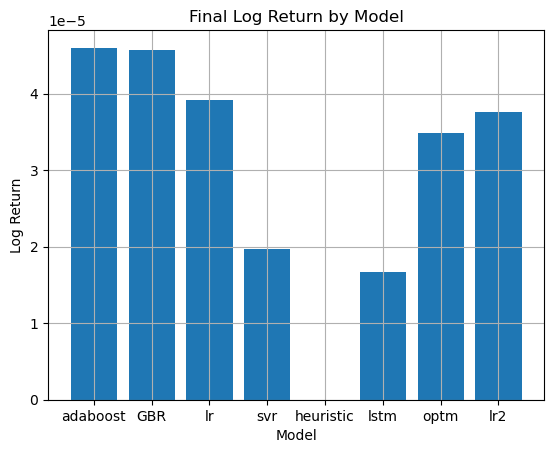

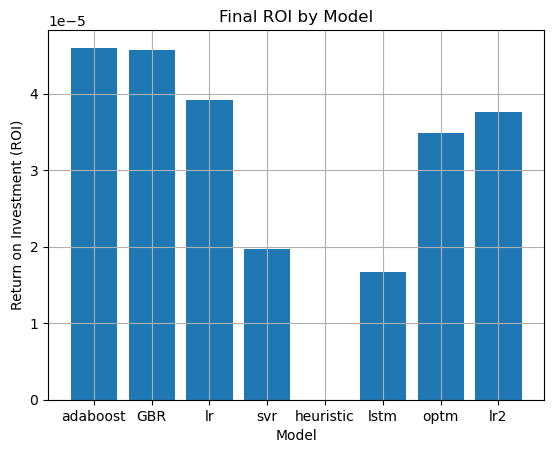

In [13]:
df = pd.read_csv("simulation_results.csv")

# 2. Extract final portfolio values and investments for each model
last = df.iloc[-1]
models = ['adaboost','GBR','lr','svr','heuristic','lstm','optm','lr2']

final_values = {m: last[f'portfolio_value_{m}'] for m in models}
investments  = {m: last[f'investment_{m}']       for m in models}

# 3. Compute ROI and log returns
roi      = {m: (final_values[m] - investments[m]) / investments[m] if investments[m] > 0 else np.nan for m in models}
log_ret  = {m: np.log(final_values[m] / investments[m]) if investments[m] > 0 else np.nan for m in models}

# 4. Plot final log return per model
plt.figure()
plt.bar(models, [log_ret[m] for m in models])
plt.xlabel("Model")
plt.ylabel("Log Return")
plt.title("Final Log Return by Model")
plt.grid(True)
plt.show()

# 5. (Optional) Plot ROI as well
plt.figure()
plt.bar(models, [roi[m] for m in models])
plt.xlabel("Model")
plt.ylabel("Return on Investment (ROI)")
plt.title("Final ROI by Model")
plt.grid(True)
plt.show()